In [ ]:
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from tqdm import tqdm
import torch, torchvision
import torch.nn.functional as F
from torch import optim, nn
var_size = 50000
thres = 0.5

# 1 for clean
# 0 for noisy

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on gpu")
else:
  device = torch.device("cpu")
  print("running on cpu")

running on gpu


In [ ]:
# !pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
# import torchaudio

# Data Preprocessing

## Loading Noisy and clean data

In [ ]:
print("Unzipping Data")
!unzip "./drive/My Drive/audionoisy.zip" 
!unzip "./drive/My Drive/audiodata.zip"
print("Unzipping Done!!")

In [ ]:
noisydata_dir = "./noisy_trainset_28spk_wav"
cleandata_dir = "./clean_trainset_28spk_wav"
usable_filename = []
clean_audio_filename = os.listdir(cleandata_dir)
noisy_audio_filename = os.listdir(noisydata_dir)

In [ ]:
def check_miss():
  for filename in clean_audio_filename:
      if(filename in noisy_audio_filename):
          usable_filename.append(filename)

  print("Miss-Matched Files:", len(noisy_audio_filename) - len(usable_filename))

check_miss()

Miss-Matched Files: 0


## Converting to numpy array and resampling

In [ ]:
def torchaudio_file_noisy():
  data_array = []
  for idx in tqdm(range(len(usable_filename))):
    data1, sr1 = torchaudio.load(noisydata_dir + "/" + usable_filename[idx])
    data1 = librosa.resample(data1[0].numpy(),sr1, 22050)
    data_array.append(data1)
  return data_array

data_noisy = torchaudio_file_noisy()
np.save("./drive/My Drive/noisyaudiodata.npy", np.array(data_noisy))

100%|██████████| 11572/11572 [23:33<00:00,  8.18it/s]


In [ ]:
def torchaudio_file_clean():
  data_array = []
  for idx in tqdm(range(len(usable_filename))):
    data2, sr2 = torchaudio.load(cleandata_dir + "/" + usable_filename[idx])
    data2 = librosa.resample(data2[0].numpy(),sr2, 22050)
    data_array.append(data2)
  return data_array
  
# data_clean = torchaudio_file_clean()
# np.save("./drive/My Drive/cleanaudiodata.npy", np.array(data_clean))

## numpy arrays to tensors

In [ ]:
data_noise = np.load("./drive/My Drive/noisyaudiodata.npy", allow_pickle=True)

In [ ]:
data_clean = np.load("./drive/My Drive/cleanaudiodata.npy", allow_pickle=True)

In [ ]:
def make_training_data(data_array, var_size):
  data_X = []

  for data in data_array:
      l = data.shape[0]
      if l < var_size:
        x = np.append(data, [np.zeros(var_size - l)])
        data_X.append(x)
      else:
        s = int(l/var_size)
        j = 0
        k = var_size
        while s > 0:
          x = data[j:k]
          j += var_size
          k += var_size
          data_X.append(x)
          s = s - 1
        if j < l:
          x = np.append(data[j:], [np.zeros(k - l)])
          data_X.append(x)
  return data_X

data_X = make_training_data(data_clean,50000)
print(len(data_X))

20937


In [ ]:
data1 = torch.Tensor([i for i in data_X[10000:20000]]).view(-1,var_size)
print(data1.size())
torch.save(data1,"./drive/My Drive/clean_data_2.pt")

torch.Size([10000, 50000])


In [ ]:
del data_X

# Other helper functions

In [ ]:
def make_data(num = 1):
  arr = np.arange(1,8)
  np.random.shuffle(arr)
  x = {}
  y = {}
  data_X = torch.Tensor([])
  for i in range(num):
    x[i] = torch.load(f"./drive/My Drive/data_X_{arr[i]}_tensor.pt")
    y[i] = torch.load(f"./drive/My Drive/data_y_{arr[i]}_tensor.pt")

  for i in range(num):
    data_X = torch.cat((data_X,x[i]))
    data_y = torch.cat((data_y,y[i]))
  del x,y
  data_y = torch.Tensor([i[0] for i in data_y])  
  
  return data_X,data_y

In [ ]:
def plot_history(d1_hist, d2_hist, g_hist):
	# plot loss
	plt.plot(d1_hist, label='d-real')
	plt.plot(d2_hist, label='d-fake')
	plt.plot(g_hist, label='gen')
	plt.legend()
	# save plot to filereloading
	plt.savefig('plot_line_plot_loss0.png')
	plt.close()

# deep learning

## discriminator

In [ ]:
class CNN_Discriminator(nn.Module):
  def __init__(self,dropout_drop = 0.5):
    super(CNN_Discriminator, self).__init__()
    neg_slope = 0.03
    self.lr = nn.LeakyReLU(neg_slope)
    # self.pool = nn.AvgPool1d(2)
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=32,stride=2)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels= 64, kernel_size=32,stride=2)
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32,stride=2)
    self.dropout1 = nn.Dropout(dropout_drop)
    self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=32,stride=2)
    self.conv5 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=32,stride=2)
    self.conv6 = nn.Conv1d(in_channels=128, out_channels=512, kernel_size=32,stride=2)
    self.dropout2 = nn.Dropout(dropout_drop)
    self.conv7 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=32,stride=2)
    self.conv8 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=32,stride=2)
    self.conv9 = nn.Conv1d(in_channels=1024, out_channels=1, kernel_size=32,stride=2)
    self.l1 = nn.Linear(67,1)
    self.sig = nn.Sigmoid()
    self.init_weights()

  def init_weights(self):
    for module in self.modules():
      if isinstance(module, nn.Conv1d):
        torch.nn.init.xavier_normal_(module.weight.data)

  def forward(self,x):

    x = self.lr(self.conv1(x))
    x = self.lr(self.conv2(x))
    x = self.lr(self.conv3(x))
    x = self.lr(self.conv4(x))
    x = self.lr(self.conv5(x))
    x = self.lr(self.conv6(x))
    x = self.dropout2(x)
    x = self.lr(self.conv7(x))
    x = self.lr(self.conv8(x))
    x = self.lr(self.conv9(x))
    x = self.sig(self.l1(x))

    return x


In [ ]:
out = dis(d)
out.size()

torch.Size([20, 1, 1])

In [ ]:
d = clean[0:BATCH_SIZE].view(BATCH_SIZE,1,var_size).to(device)

## Generator

In [ ]:
def sample_latent(b):
  return torch.randn((b,1024, 195))

In [ ]:
def set_size(t,count):
  temp = torch.zeros([t.size()[0],t.size()[1],count]).to(device)
  return torch.cat((t,temp), dim=2)

In [ ]:
class CNN_Generator(nn.Module):
  def __init__(self):
    super(CNN_Generator,self).__init__()
    neg_slope = 0.03

    # self.pool = nn.MaxPool1d(2)
    
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=32,stride=2,padding = 15)        
    self.pr1 = nn.PReLU()
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32,stride=2,padding = 15)
    self.pr2 = nn.PReLU()
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=32,stride=2,padding = 15)
    self.pr3 = nn.PReLU()
    self.conv4 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=32,stride=2,padding = 15)
    self.pr4 = nn.PReLU()
    self.conv5 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=32,stride=2,padding = 15)
    self.pr5 = nn.PReLU()
    self.conv6 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=32,stride=2,padding = 15)
    self.pr6 = nn.PReLU()
    self.conv7 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=32,stride=2,padding = 15)
    self.pr7 = nn.PReLU()
    self.conv8 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=32,stride=2,padding = 15)
    self.pr8 = nn.PReLU()

    self.decon8 = nn.ConvTranspose1d(in_channels=2048, out_channels=512, kernel_size=32,stride=2,padding = 15)
    self.dpr8 = nn.PReLU()
    self.decon7 = nn.ConvTranspose1d(in_channels=1024, out_channels=512, kernel_size=32,stride=2,padding = 15)
    self.dpr7 = nn.PReLU()
    self.decon6 = nn.ConvTranspose1d(in_channels=1024, out_channels=256, kernel_size=32,stride=2,padding = 15)
    self.dpr6 = nn.PReLU()
    self.decon5 = nn.ConvTranspose1d(in_channels=512, out_channels=128, kernel_size=32,stride=2,padding = 15)
    self.dpr5 = nn.PReLU()
    self.decon4 = nn.ConvTranspose1d(in_channels=256, out_channels=128, kernel_size=32,stride=2,padding = 15)
    self.dpr4 = nn.PReLU()
    self.decon3 = nn.ConvTranspose1d(in_channels=256, out_channels=64, kernel_size=32,stride=2,padding = 15)
    self.dpr3 = nn.PReLU()
    self.decon2 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=32,stride=2,padding = 15)
    self.dpr2 = nn.PReLU()
    self.decon1 = nn.ConvTranspose1d(in_channels=128, out_channels=1, kernel_size=32,stride=2,padding = 15)
    self.tanh = nn.Tanh()
    
    self.init_weights()

  def init_weights(self):
    for module in self.modules():
      if isinstance(module, nn.Conv1d) or isinstance(module, nn.ConvTranspose1d):
        torch.nn.init.xavier_normal_(module.weight.data)

  def forward(self,x,z):
    c1 = self.pr1(self.conv1(x))  
    # print("c1 -- ",c1.size())
    c2 = self.pr2(self.conv2(c1))
    # print("c2-- ",c2.size())
    c3 = self.pr3(self.conv3(c2))
    # print("c3-- ",c3.size())
    c4 = self.pr4(self.conv4(c3))
    # print("c4-- ",c4.size())
    c5 = self.pr5(self.conv5(c4))
    # print("c5-- ",c5.size())
    c6 = self.pr6(self.conv6(c5))
    # print("c6-- ",c6.size())
    c7 = self.pr7(self.conv7(c6))
    # print("c7-- ",c7.size())
    c8 = self.pr8(self.conv8(c7))
    # print("c8-- ",c8.size())

    enc8 = torch.cat((c8,z), dim=1)
    # print("enc8 -- ",enc8.size())
    tc8 = self.dpr8(self.decon8(enc8))
    # print("tc8-- ",tc8.size())

    enc7 = torch.cat((tc8,c7),dim=1)
    # print("enc7 -- ",enc7.size())
    tc7 = self.dpr7(self.decon7(enc7))
    # print("tc7-- ",tc7.size())

    tc7 = set_size(tc7,1)
    enc6 = torch.cat((tc7,c6),dim=1)
    # print("enc6 -- ",enc6.size())
    tc6 = self.dpr6(self.decon6(enc6))
    # print("tc6-- ",tc6.size())

    enc5 = torch.cat((tc6,c5),dim=1)
    # print("enc5 -- ",enc5.size())
    tc5 = self.dpr5(self.decon5(enc5))
    # print("tc5-- ",tc5.size())

    tc5 = set_size(tc5,1)
    enc4 = torch.cat((tc5,c4),dim=1)
    # print("enc4 -- ",enc4.size())
    tc4 = self.dpr4(self.decon4(enc4))
    # print("tc4-- ",tc4.size())
    
    enc3 = torch.cat((tc4,c3),dim=1)
    # print("enc3 -- ",enc3.size())
    tc3 = self.dpr3(self.decon3(enc3))
    # print("tc3-- ",tc3.size())
    
    enc2 = torch.cat((tc3,c2),dim=1)
    # print("enc2 -- ",enc2.size())
    tc2 = self.dpr2(self.decon2(enc2))
    # print("tc2-- ",tc2.size())

    enc1 = torch.cat((tc2,c1),dim=1)
    # print("enc1 -- ",enc1.size())
    tc1 = self.tanh(self.decon1(enc1))
    # print("tc1-- ",tc1.size())
    return tc1


In [ ]:
gen(d,z).size()

In [ ]:
d = clean[0:BATCH_SIZE].view(BATCH_SIZE,1,var_size).to(device)
z = sample_latent(BATCH_SIZE).to(device)

## Training

In [ ]:
BATCH_SIZE = 20
EPOCHS = 10
g_lambda = 1
plot_count = 0

In [ ]:
def load_data(i = 1):
  clean = torch.load(f"./drive/My Drive/clean_data_{i}.pt")
  noisy = torch.load(f"./drive/My Drive/noisy_data_{i}.pt")

  return clean,noisy

In [ ]:
def create_batch(clean,noisy,i):
  batch_clean = clean[i:i+BATCH_SIZE].view(BATCH_SIZE,1,var_size)
  batch_noisy = noisy[i:i+BATCH_SIZE].view(BATCH_SIZE,1,var_size)
  batch_clean,batch_noisy = batch_clean.to(device),batch_noisy.to(device=device)

  return batch_clean,batch_noisy


In [ ]:
def train_dis(gen,dis,batch_clean,batch_noisy,do):
  
  real_c = dis(batch_clean)
  real_n = dis(batch_noisy)
  real_loss = torch.mean((real_c - 1)**2) + torch.mean((real_n)**2)
                          
  z = sample_latent(BATCH_SIZE).to(device)
  gen_out = gen(batch_noisy,z)
  
  fake_d = dis(gen_out)
  fake_loss = torch.mean((fake_d)**2)

  d_loss = (real_loss + fake_loss )/3
  
  do.zero_grad()
  d_loss.backward()
  do.step()

  return real_loss.item(),fake_loss.item(),d_loss.item()

In [ ]:
def train_gen(gen,dis,batch_clean,batch_noisy,go):
  z = sample_latent(BATCH_SIZE).to(device)
      
  fake_g = dis(gen(batch_noisy,z))
  l1_dist = torch.mean(torch.add(fake_g, torch.neg(batch_clean)))
  
  g_loss = torch.mean((fake_g - 1)**2) + (g_lambda * l1_dist) 
  
  go.zero_grad()
  g_loss.backward()
  go.step()

  return g_loss.item()


In [ ]:
def train(gen,dis,clean,noisy,alt):
  go = optim.Adam(gen.parameters(), lr= 0.0001)
  do = optim.Adam(dis.parameters(), lr= 0.0001)
  d1_hist, d2_hist, g_hist = list(), list(), list()
  data_size = len(clean)
  for epoch in range(EPOCHS):
    rl = 0
    gl = 0
    for i in tqdm(range(0,data_size,BATCH_SIZE)):
      
      batch_clean,batch_noisy = create_batch(clean,noisy,i)

      if epoch%alt == 0:
        real_loss,fake_loss,d_loss = train_dis(gen,dis,batch_clean,batch_noisy,do)
        d1_hist.append(real_loss)
        d2_hist.append(fake_loss)
        rl += d_loss
      else:
        g_loss = train_gen(gen,dis,batch_clean,batch_noisy,go)
        g_hist.append(g_loss)
        gl += g_loss

    if epoch%alt == 0:
      print(f"{epoch} -- > dis-avg-loss = {rl/(data_size/BATCH_SIZE)}")
    else:
      print(f"{epoch} -- > gen-avg-loss = {gl/(data_size/BATCH_SIZE)}")

  plot_history(d1_hist, d2_hist, g_hist)


In [ ]:
# train dis and gen alternatively


In [ ]:
clean,noisy = load_data()
train(gen,dis,clean,noisy)

In [ ]:
del clean,noisy

### single data point

In [ ]:
clean,noisy = load_data()

In [ ]:
i = 10
one_clean = clean[0:i].view(i,1,var_size)
one_noisy = noisy[0:i].view(i,1,var_size)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 5
EPOCHS = 250
g_lambda = 1
plot_count = 0

In [ ]:
dis = CNN_Discriminator().to(device)
gen = CNN_Generator().to(device)

In [ ]:
train(gen,dis,one_clean,one_noisy,5)

  0%|          | 0/2 [00:00<?, ?it/s]

0 -- > dis-avg-loss = 0.25594498217105865


  0%|          | 0/2 [00:00<?, ?it/s]

1 -- > gen-avg-loss = 0.7502366304397583


  0%|          | 0/2 [00:00<?, ?it/s]

2 -- > gen-avg-loss = 0.750228762626648


  0%|          | 0/2 [00:00<?, ?it/s]

3 -- > gen-avg-loss = 0.7502385973930359


  0%|          | 0/2 [00:00<?, ?it/s]

4 -- > gen-avg-loss = 0.7502414584159851


  0%|          | 0/2 [00:00<?, ?it/s]

5 -- > dis-avg-loss = 0.25492623448371887


  0%|          | 0/2 [00:00<?, ?it/s]

6 -- > gen-avg-loss = 0.7501650452613831


  0%|          | 0/2 [00:00<?, ?it/s]

7 -- > gen-avg-loss = 0.7501652240753174


  0%|          | 0/2 [00:00<?, ?it/s]

8 -- > gen-avg-loss = 0.750165194272995


  0%|          | 0/2 [00:00<?, ?it/s]

9 -- > gen-avg-loss = 0.750165194272995


  0%|          | 0/2 [00:00<?, ?it/s]

10 -- > dis-avg-loss = 0.25434504449367523


  0%|          | 0/2 [00:00<?, ?it/s]

11 -- > gen-avg-loss = 0.7501600086688995


  0%|          | 0/2 [00:00<?, ?it/s]

12 -- > gen-avg-loss = 0.7501601278781891


  0%|          | 0/2 [00:00<?, ?it/s]

13 -- > gen-avg-loss = 0.7501600980758667


  0%|          | 0/2 [00:00<?, ?it/s]

14 -- > gen-avg-loss = 0.7501600980758667


  0%|          | 0/2 [00:00<?, ?it/s]

15 -- > dis-avg-loss = 0.2542749047279358


  0%|          | 0/2 [00:00<?, ?it/s]

16 -- > gen-avg-loss = 0.7501534521579742


  0%|          | 0/2 [00:00<?, ?it/s]

17 -- > gen-avg-loss = 0.7501539587974548


  0%|          | 0/2 [00:00<?, ?it/s]

18 -- > gen-avg-loss = 0.7501533627510071


  0%|          | 0/2 [00:00<?, ?it/s]

19 -- > gen-avg-loss = 0.7501533329486847


  0%|          | 0/2 [00:00<?, ?it/s]

20 -- > dis-avg-loss = 0.25415436923503876


  0%|          | 0/2 [00:00<?, ?it/s]

21 -- > gen-avg-loss = 0.7501414716243744


  0%|          | 0/2 [00:00<?, ?it/s]

22 -- > gen-avg-loss = 0.7501409649848938


  0%|          | 0/2 [00:00<?, ?it/s]

23 -- > gen-avg-loss = 0.7501391470432281


  0%|          | 0/2 [00:00<?, ?it/s]

24 -- > gen-avg-loss = 0.7501371502876282


  0%|          | 0/2 [00:00<?, ?it/s]

25 -- > dis-avg-loss = 0.25381509959697723


  0%|          | 0/2 [00:00<?, ?it/s]

26 -- > gen-avg-loss = 0.7500908970832825


  0%|          | 0/2 [00:00<?, ?it/s]

27 -- > gen-avg-loss = 0.7500829994678497


  0%|          | 0/2 [00:00<?, ?it/s]

28 -- > gen-avg-loss = 0.7500798404216766


  0%|          | 0/2 [00:00<?, ?it/s]

29 -- > gen-avg-loss = 0.7500813901424408


  0%|          | 0/2 [00:00<?, ?it/s]

30 -- > dis-avg-loss = 0.2524106353521347


  0%|          | 0/2 [00:00<?, ?it/s]

31 -- > gen-avg-loss = 0.7500088214874268


  0%|          | 0/2 [00:00<?, ?it/s]

32 -- > gen-avg-loss = 0.7500084936618805


  0%|          | 0/2 [00:00<?, ?it/s]

33 -- > gen-avg-loss = 0.7500083744525909


  0%|          | 0/2 [00:00<?, ?it/s]

34 -- > gen-avg-loss = 0.7500084042549133


  0%|          | 0/2 [00:00<?, ?it/s]

35 -- > dis-avg-loss = 0.24727903306484222


  0%|          | 0/2 [00:00<?, ?it/s]

36 -- > gen-avg-loss = 0.7519329786300659


  0%|          | 0/2 [00:00<?, ?it/s]

37 -- > gen-avg-loss = 0.7519223690032959


  0%|          | 0/2 [00:00<?, ?it/s]

38 -- > gen-avg-loss = 0.7519140541553497


  0%|          | 0/2 [00:00<?, ?it/s]

39 -- > gen-avg-loss = 0.7519112527370453


  0%|          | 0/2 [00:00<?, ?it/s]

40 -- > dis-avg-loss = 0.22815380990505219


  0%|          | 0/2 [00:00<?, ?it/s]

41 -- > gen-avg-loss = 0.7904091477394104


  0%|          | 0/2 [00:00<?, ?it/s]

42 -- > gen-avg-loss = 0.7914581298828125


  0%|          | 0/2 [00:00<?, ?it/s]

43 -- > gen-avg-loss = 0.7914962768554688


  0%|          | 0/2 [00:00<?, ?it/s]

44 -- > gen-avg-loss = 0.7916845381259918


  0%|          | 0/2 [00:00<?, ?it/s]

45 -- > dis-avg-loss = 0.18698010593652725


  0%|          | 0/2 [00:00<?, ?it/s]

46 -- > gen-avg-loss = 0.9702035188674927


  0%|          | 0/2 [00:00<?, ?it/s]

47 -- > gen-avg-loss = 0.9711770713329315


  0%|          | 0/2 [00:00<?, ?it/s]

48 -- > gen-avg-loss = 0.9701292514801025


  0%|          | 0/2 [00:00<?, ?it/s]

49 -- > gen-avg-loss = 0.9706692099571228


  0%|          | 0/2 [00:00<?, ?it/s]

50 -- > dis-avg-loss = 0.1808929666876793


  0%|          | 0/2 [00:00<?, ?it/s]

51 -- > gen-avg-loss = 0.9988272488117218


  0%|          | 0/2 [00:00<?, ?it/s]

52 -- > gen-avg-loss = 0.9988518357276917


  0%|          | 0/2 [00:00<?, ?it/s]

53 -- > gen-avg-loss = 0.9987866282463074


  0%|          | 0/2 [00:00<?, ?it/s]

54 -- > gen-avg-loss = 0.9988520741462708


  0%|          | 0/2 [00:00<?, ?it/s]

55 -- > dis-avg-loss = 0.18435099720954895


  0%|          | 0/2 [00:00<?, ?it/s]

56 -- > gen-avg-loss = 0.999085396528244


  0%|          | 0/2 [00:00<?, ?it/s]

57 -- > gen-avg-loss = 0.999083936214447


  0%|          | 0/2 [00:00<?, ?it/s]

58 -- > gen-avg-loss = 0.9990719556808472


  0%|          | 0/2 [00:00<?, ?it/s]

59 -- > gen-avg-loss = 0.9990863502025604


  0%|          | 0/2 [00:00<?, ?it/s]

60 -- > dis-avg-loss = 0.17219165712594986


  0%|          | 0/2 [00:00<?, ?it/s]

61 -- > gen-avg-loss = 0.9974222183227539


  0%|          | 0/2 [00:00<?, ?it/s]

62 -- > gen-avg-loss = 0.9973007142543793


  0%|          | 0/2 [00:00<?, ?it/s]

63 -- > gen-avg-loss = 0.9973101615905762


  0%|          | 0/2 [00:00<?, ?it/s]

64 -- > gen-avg-loss = 0.9974298477172852


  0%|          | 0/2 [00:00<?, ?it/s]

65 -- > dis-avg-loss = 0.1671043485403061


  0%|          | 0/2 [00:00<?, ?it/s]

66 -- > gen-avg-loss = 0.9930233657360077


  0%|          | 0/2 [00:00<?, ?it/s]

67 -- > gen-avg-loss = 0.9926068484783173


  0%|          | 0/2 [00:00<?, ?it/s]

68 -- > gen-avg-loss = 0.9927235245704651


  0%|          | 0/2 [00:00<?, ?it/s]

69 -- > gen-avg-loss = 0.9930499792098999


  0%|          | 0/2 [00:00<?, ?it/s]

70 -- > dis-avg-loss = 0.16662824153900146


  0%|          | 0/2 [00:00<?, ?it/s]

71 -- > gen-avg-loss = 0.9864560663700104


  0%|          | 0/2 [00:00<?, ?it/s]

72 -- > gen-avg-loss = 0.9865531921386719


  0%|          | 0/2 [00:00<?, ?it/s]

73 -- > gen-avg-loss = 0.9866275191307068


  0%|          | 0/2 [00:00<?, ?it/s]

74 -- > gen-avg-loss = 0.986670970916748


  0%|          | 0/2 [00:00<?, ?it/s]

75 -- > dis-avg-loss = 0.16680509597063065


  0%|          | 0/2 [00:00<?, ?it/s]

76 -- > gen-avg-loss = 0.9801725447177887


  0%|          | 0/2 [00:00<?, ?it/s]

77 -- > gen-avg-loss = 0.9804683923721313


  0%|          | 0/2 [00:00<?, ?it/s]

78 -- > gen-avg-loss = 0.9794217944145203


  0%|          | 0/2 [00:00<?, ?it/s]

79 -- > gen-avg-loss = 0.9798603355884552


  0%|          | 0/2 [00:00<?, ?it/s]

80 -- > dis-avg-loss = 0.16691435873508453


  0%|          | 0/2 [00:00<?, ?it/s]

81 -- > gen-avg-loss = 0.9768127799034119


  0%|          | 0/2 [00:00<?, ?it/s]

82 -- > gen-avg-loss = 0.9763967990875244


  0%|          | 0/2 [00:00<?, ?it/s]

83 -- > gen-avg-loss = 0.9768162071704865


  0%|          | 0/2 [00:00<?, ?it/s]

84 -- > gen-avg-loss = 0.9763786792755127


  0%|          | 0/2 [00:00<?, ?it/s]

85 -- > dis-avg-loss = 0.16692987084388733


  0%|          | 0/2 [00:00<?, ?it/s]

86 -- > gen-avg-loss = 0.9776267409324646


  0%|          | 0/2 [00:00<?, ?it/s]

87 -- > gen-avg-loss = 0.9776535034179688


  0%|          | 0/2 [00:00<?, ?it/s]

88 -- > gen-avg-loss = 0.9769169092178345


  0%|          | 0/2 [00:00<?, ?it/s]

89 -- > gen-avg-loss = 0.976863443851471


  0%|          | 0/2 [00:00<?, ?it/s]

90 -- > dis-avg-loss = 0.16686808317899704


  0%|          | 0/2 [00:00<?, ?it/s]

91 -- > gen-avg-loss = 0.9804665446281433


  0%|          | 0/2 [00:00<?, ?it/s]

92 -- > gen-avg-loss = 0.9802770614624023


  0%|          | 0/2 [00:00<?, ?it/s]

93 -- > gen-avg-loss = 0.9810820519924164


  0%|          | 0/2 [00:00<?, ?it/s]

94 -- > gen-avg-loss = 0.9811558425426483


  0%|          | 0/2 [00:00<?, ?it/s]

95 -- > dis-avg-loss = 0.16679569333791733


  0%|          | 0/2 [00:00<?, ?it/s]

96 -- > gen-avg-loss = 0.985001266002655


  0%|          | 0/2 [00:00<?, ?it/s]

97 -- > gen-avg-loss = 0.9853432476520538


  0%|          | 0/2 [00:00<?, ?it/s]

98 -- > gen-avg-loss = 0.9851474463939667


  0%|          | 0/2 [00:00<?, ?it/s]

99 -- > gen-avg-loss = 0.9846318364143372


  0%|          | 0/2 [00:00<?, ?it/s]

100 -- > dis-avg-loss = 0.16674459725618362


  0%|          | 0/2 [00:00<?, ?it/s]

101 -- > gen-avg-loss = 0.9893574118614197


  0%|          | 0/2 [00:00<?, ?it/s]

102 -- > gen-avg-loss = 0.9889585375785828


  0%|          | 0/2 [00:00<?, ?it/s]

103 -- > gen-avg-loss = 0.9896007776260376


  0%|          | 0/2 [00:00<?, ?it/s]

104 -- > gen-avg-loss = 0.9895713329315186


  0%|          | 0/2 [00:00<?, ?it/s]

105 -- > dis-avg-loss = 0.16672970354557037


  0%|          | 0/2 [00:00<?, ?it/s]

106 -- > gen-avg-loss = 0.9924920499324799


  0%|          | 0/2 [00:00<?, ?it/s]

107 -- > gen-avg-loss = 0.9925417602062225


  0%|          | 0/2 [00:00<?, ?it/s]

108 -- > gen-avg-loss = 0.9924823045730591


  0%|          | 0/2 [00:00<?, ?it/s]

109 -- > gen-avg-loss = 0.9923890233039856


  0%|          | 0/2 [00:00<?, ?it/s]

110 -- > dis-avg-loss = 0.16666263341903687


  0%|          | 0/2 [00:00<?, ?it/s]

111 -- > gen-avg-loss = 0.9946367144584656


  0%|          | 0/2 [00:00<?, ?it/s]

112 -- > gen-avg-loss = 0.9946646690368652


  0%|          | 0/2 [00:00<?, ?it/s]

113 -- > gen-avg-loss = 0.9946162700653076


  0%|          | 0/2 [00:00<?, ?it/s]

114 -- > gen-avg-loss = 0.9947778284549713


  0%|          | 0/2 [00:00<?, ?it/s]

115 -- > dis-avg-loss = 0.1666741669178009


  0%|          | 0/2 [00:00<?, ?it/s]

116 -- > gen-avg-loss = 0.9961181879043579


  0%|          | 0/2 [00:00<?, ?it/s]

117 -- > gen-avg-loss = 0.9960869252681732


  0%|          | 0/2 [00:00<?, ?it/s]

118 -- > gen-avg-loss = 0.9962396919727325


  0%|          | 0/2 [00:00<?, ?it/s]

119 -- > gen-avg-loss = 0.9963149130344391


  0%|          | 0/2 [00:00<?, ?it/s]

120 -- > dis-avg-loss = 0.1667039692401886


  0%|          | 0/2 [00:00<?, ?it/s]

121 -- > gen-avg-loss = 0.9974379241466522


  0%|          | 0/2 [00:00<?, ?it/s]

122 -- > gen-avg-loss = 0.9973233044147491


  0%|          | 0/2 [00:00<?, ?it/s]

123 -- > gen-avg-loss = 0.997347503900528


  0%|          | 0/2 [00:00<?, ?it/s]

124 -- > gen-avg-loss = 0.9973093569278717


  0%|          | 0/2 [00:00<?, ?it/s]

125 -- > dis-avg-loss = 0.16659224033355713


  0%|          | 0/2 [00:00<?, ?it/s]

126 -- > gen-avg-loss = 0.9980100691318512


  0%|          | 0/2 [00:00<?, ?it/s]

127 -- > gen-avg-loss = 0.997993528842926


  0%|          | 0/2 [00:00<?, ?it/s]

128 -- > gen-avg-loss = 0.9982027411460876


  0%|          | 0/2 [00:00<?, ?it/s]

129 -- > gen-avg-loss = 0.9980277121067047


  0%|          | 0/2 [00:00<?, ?it/s]

130 -- > dis-avg-loss = 0.1665770336985588


  0%|          | 0/2 [00:00<?, ?it/s]

131 -- > gen-avg-loss = 0.9984523355960846


  0%|          | 0/2 [00:00<?, ?it/s]

132 -- > gen-avg-loss = 0.9985500276088715


  0%|          | 0/2 [00:00<?, ?it/s]

133 -- > gen-avg-loss = 0.9984836578369141


  0%|          | 0/2 [00:00<?, ?it/s]

134 -- > gen-avg-loss = 0.9985723197460175


  0%|          | 0/2 [00:00<?, ?it/s]

135 -- > dis-avg-loss = 0.166596919298172


  0%|          | 0/2 [00:00<?, ?it/s]

136 -- > gen-avg-loss = 0.9988906979560852


  0%|          | 0/2 [00:00<?, ?it/s]

137 -- > gen-avg-loss = 0.9988522529602051


  0%|          | 0/2 [00:00<?, ?it/s]

138 -- > gen-avg-loss = 0.9988650679588318


  0%|          | 0/2 [00:00<?, ?it/s]

139 -- > gen-avg-loss = 0.9988378584384918


  0%|          | 0/2 [00:00<?, ?it/s]

140 -- > dis-avg-loss = 0.16643676161766052


  0%|          | 0/2 [00:00<?, ?it/s]

141 -- > gen-avg-loss = 0.9991328418254852


  0%|          | 0/2 [00:00<?, ?it/s]

142 -- > gen-avg-loss = 0.9991470277309418


  0%|          | 0/2 [00:00<?, ?it/s]

143 -- > gen-avg-loss = 0.9991442263126373


  0%|          | 0/2 [00:00<?, ?it/s]

144 -- > gen-avg-loss = 0.9991810321807861


  0%|          | 0/2 [00:00<?, ?it/s]

145 -- > dis-avg-loss = 0.1663121059536934


  0%|          | 0/2 [00:00<?, ?it/s]

146 -- > gen-avg-loss = 0.9993463754653931


  0%|          | 0/2 [00:00<?, ?it/s]

147 -- > gen-avg-loss = 0.9993738234043121


  0%|          | 0/2 [00:00<?, ?it/s]

148 -- > gen-avg-loss = 0.9993480443954468


  0%|          | 0/2 [00:00<?, ?it/s]

149 -- > gen-avg-loss = 0.9993331432342529


  0%|          | 0/2 [00:00<?, ?it/s]

150 -- > dis-avg-loss = 0.16635677218437195


  0%|          | 0/2 [00:00<?, ?it/s]

151 -- > gen-avg-loss = 0.9994626939296722


  0%|          | 0/2 [00:00<?, ?it/s]

152 -- > gen-avg-loss = 0.9994761943817139


  0%|          | 0/2 [00:00<?, ?it/s]

153 -- > gen-avg-loss = 0.9994874894618988


  0%|          | 0/2 [00:00<?, ?it/s]

154 -- > gen-avg-loss = 0.9995105564594269


  0%|          | 0/2 [00:00<?, ?it/s]

155 -- > dis-avg-loss = 0.1659776121377945


  0%|          | 0/2 [00:00<?, ?it/s]

156 -- > gen-avg-loss = 0.9996138513088226


  0%|          | 0/2 [00:00<?, ?it/s]

157 -- > gen-avg-loss = 0.9996006488800049


  0%|          | 0/2 [00:00<?, ?it/s]

158 -- > gen-avg-loss = 0.9995982944965363


  0%|          | 0/2 [00:00<?, ?it/s]

159 -- > gen-avg-loss = 0.9995821416378021


  0%|          | 0/2 [00:00<?, ?it/s]

160 -- > dis-avg-loss = 0.16607765853405


  0%|          | 0/2 [00:00<?, ?it/s]

161 -- > gen-avg-loss = 0.9997397065162659


  0%|          | 0/2 [00:00<?, ?it/s]

162 -- > gen-avg-loss = 0.9997195601463318


  0%|          | 0/2 [00:00<?, ?it/s]

163 -- > gen-avg-loss = 0.9996956288814545


  0%|          | 0/2 [00:00<?, ?it/s]

164 -- > gen-avg-loss = 0.9997191429138184


  0%|          | 0/2 [00:00<?, ?it/s]

165 -- > dis-avg-loss = 0.16562791913747787


  0%|          | 0/2 [00:00<?, ?it/s]

166 -- > gen-avg-loss = 0.9997984170913696


  0%|          | 0/2 [00:00<?, ?it/s]

167 -- > gen-avg-loss = 0.9998148381710052


  0%|          | 0/2 [00:00<?, ?it/s]

168 -- > gen-avg-loss = 0.9997840225696564


  0%|          | 0/2 [00:00<?, ?it/s]

169 -- > gen-avg-loss = 0.999792069196701


  0%|          | 0/2 [00:00<?, ?it/s]

170 -- > dis-avg-loss = 0.16532345116138458


  0%|          | 0/2 [00:00<?, ?it/s]

171 -- > gen-avg-loss = 0.9998781383037567


  0%|          | 0/2 [00:00<?, ?it/s]

172 -- > gen-avg-loss = 0.9998717606067657


  0%|          | 0/2 [00:00<?, ?it/s]

173 -- > gen-avg-loss = 0.9998800754547119


  0%|          | 0/2 [00:00<?, ?it/s]

174 -- > gen-avg-loss = 0.9998797476291656


  0%|          | 0/2 [00:00<?, ?it/s]

175 -- > dis-avg-loss = 0.16543778032064438


  0%|          | 0/2 [00:00<?, ?it/s]

176 -- > gen-avg-loss = 0.9999032914638519


  0%|          | 0/2 [00:00<?, ?it/s]

177 -- > gen-avg-loss = 0.9999043047428131


  0%|          | 0/2 [00:00<?, ?it/s]

178 -- > gen-avg-loss = 0.9999014735221863


  0%|          | 0/2 [00:00<?, ?it/s]

179 -- > gen-avg-loss = 0.9998992681503296


  0%|          | 0/2 [00:00<?, ?it/s]

180 -- > dis-avg-loss = 0.16593921184539795


  0%|          | 0/2 [00:00<?, ?it/s]

181 -- > gen-avg-loss = 0.9999085068702698


  0%|          | 0/2 [00:00<?, ?it/s]

182 -- > gen-avg-loss = 0.9999019503593445


  0%|          | 0/2 [00:00<?, ?it/s]

183 -- > gen-avg-loss = 0.9999174475669861


  0%|          | 0/2 [00:00<?, ?it/s]

184 -- > gen-avg-loss = 0.9999091327190399


  0%|          | 0/2 [00:00<?, ?it/s]

185 -- > dis-avg-loss = 0.16433050483465195


  0%|          | 0/2 [00:00<?, ?it/s]

186 -- > gen-avg-loss = 0.9999266266822815


  0%|          | 0/2 [00:00<?, ?it/s]

187 -- > gen-avg-loss = 0.9999218285083771


  0%|          | 0/2 [00:00<?, ?it/s]

188 -- > gen-avg-loss = 0.999920129776001


  0%|          | 0/2 [00:00<?, ?it/s]

189 -- > gen-avg-loss = 0.9999211132526398


  0%|          | 0/2 [00:00<?, ?it/s]

190 -- > dis-avg-loss = 0.16469036787748337


  0%|          | 0/2 [00:00<?, ?it/s]

191 -- > gen-avg-loss = 0.9999474585056305


  0%|          | 0/2 [00:00<?, ?it/s]

192 -- > gen-avg-loss = 0.9999473392963409


  0%|          | 0/2 [00:00<?, ?it/s]

193 -- > gen-avg-loss = 0.9999448657035828


  0%|          | 0/2 [00:00<?, ?it/s]

194 -- > gen-avg-loss = 0.9999409019947052


  0%|          | 0/2 [00:00<?, ?it/s]

195 -- > dis-avg-loss = 0.1637408286333084


  0%|          | 0/2 [00:00<?, ?it/s]

196 -- > gen-avg-loss = 0.9999729692935944


  0%|          | 0/2 [00:00<?, ?it/s]

197 -- > gen-avg-loss = 0.9999651610851288


  0%|          | 0/2 [00:00<?, ?it/s]

198 -- > gen-avg-loss = 0.9999700784683228


  0%|          | 0/2 [00:00<?, ?it/s]

199 -- > gen-avg-loss = 0.999968409538269


  0%|          | 0/2 [00:00<?, ?it/s]

200 -- > dis-avg-loss = 0.1641879826784134


  0%|          | 0/2 [00:00<?, ?it/s]

201 -- > gen-avg-loss = 0.9999794363975525


  0%|          | 0/2 [00:00<?, ?it/s]

202 -- > gen-avg-loss = 0.9999805390834808


  0%|          | 0/2 [00:00<?, ?it/s]

203 -- > gen-avg-loss = 0.9999797940254211


  0%|          | 0/2 [00:00<?, ?it/s]

204 -- > gen-avg-loss = 0.999980241060257


  0%|          | 0/2 [00:00<?, ?it/s]

205 -- > dis-avg-loss = 0.16219695657491684


  0%|          | 0/2 [00:00<?, ?it/s]

206 -- > gen-avg-loss = 0.9999919533729553


  0%|          | 0/2 [00:00<?, ?it/s]

207 -- > gen-avg-loss = 0.9999909400939941


  0%|          | 0/2 [00:00<?, ?it/s]

208 -- > gen-avg-loss = 0.9999900758266449


  0%|          | 0/2 [00:00<?, ?it/s]

209 -- > gen-avg-loss = 0.9999901354312897


  0%|          | 0/2 [00:00<?, ?it/s]

210 -- > dis-avg-loss = 0.16163333505392075


  0%|          | 0/2 [00:00<?, ?it/s]

211 -- > gen-avg-loss = 0.9999986886978149


  0%|          | 0/2 [00:00<?, ?it/s]

212 -- > gen-avg-loss = 0.9999977648258209


  0%|          | 0/2 [00:00<?, ?it/s]

213 -- > gen-avg-loss = 0.9999980330467224


  0%|          | 0/2 [00:00<?, ?it/s]

214 -- > gen-avg-loss = 0.9999974370002747


  0%|          | 0/2 [00:00<?, ?it/s]

215 -- > dis-avg-loss = 0.1693388596177101


  0%|          | 0/2 [00:00<?, ?it/s]

216 -- > gen-avg-loss = 0.9999987781047821


  0%|          | 0/2 [00:00<?, ?it/s]

217 -- > gen-avg-loss = 0.9999999701976776


  0%|          | 0/2 [00:00<?, ?it/s]

218 -- > gen-avg-loss = 0.9999991655349731


  0%|          | 0/2 [00:00<?, ?it/s]

219 -- > gen-avg-loss = 1.0000000596046448


  0%|          | 0/2 [00:00<?, ?it/s]

220 -- > dis-avg-loss = 0.16226089000701904


  0%|          | 0/2 [00:00<?, ?it/s]

221 -- > gen-avg-loss = 1.0000012814998627


  0%|          | 0/2 [00:00<?, ?it/s]

222 -- > gen-avg-loss = 1.0000004172325134


  0%|          | 0/2 [00:00<?, ?it/s]

223 -- > gen-avg-loss = 1.0000015795230865


  0%|          | 0/2 [00:00<?, ?it/s]

224 -- > gen-avg-loss = 1.0000003576278687


  0%|          | 0/2 [00:00<?, ?it/s]

225 -- > dis-avg-loss = 0.15957677364349365


  0%|          | 0/2 [00:00<?, ?it/s]

226 -- > gen-avg-loss = 1.0000016689300537


  0%|          | 0/2 [00:00<?, ?it/s]

227 -- > gen-avg-loss = 1.0000019073486328


  0%|          | 0/2 [00:00<?, ?it/s]

228 -- > gen-avg-loss = 1.000001072883606


  0%|          | 0/2 [00:00<?, ?it/s]

229 -- > gen-avg-loss = 1.000001221895218


  0%|          | 0/2 [00:00<?, ?it/s]

230 -- > dis-avg-loss = 0.16154053807258606


  0%|          | 0/2 [00:00<?, ?it/s]

231 -- > gen-avg-loss = 0.9999952614307404


  0%|          | 0/2 [00:00<?, ?it/s]

232 -- > gen-avg-loss = 0.9999936819076538


  0%|          | 0/2 [00:00<?, ?it/s]

233 -- > gen-avg-loss = 0.9999950230121613


  0%|          | 0/2 [00:00<?, ?it/s]

234 -- > gen-avg-loss = 0.999994695186615


  0%|          | 0/2 [00:00<?, ?it/s]

235 -- > dis-avg-loss = 0.17164670675992966


  0%|          | 0/2 [00:00<?, ?it/s]

236 -- > gen-avg-loss = 0.9999838173389435


  0%|          | 0/2 [00:00<?, ?it/s]

237 -- > gen-avg-loss = 0.9999875426292419


  0%|          | 0/2 [00:00<?, ?it/s]

238 -- > gen-avg-loss = 0.9999856054782867


  0%|          | 0/2 [00:00<?, ?it/s]

239 -- > gen-avg-loss = 0.9999864101409912


  0%|          | 0/2 [00:00<?, ?it/s]

240 -- > dis-avg-loss = 0.17490466684103012


  0%|          | 0/2 [00:00<?, ?it/s]

241 -- > gen-avg-loss = 1.0000009834766388


  0%|          | 0/2 [00:00<?, ?it/s]

242 -- > gen-avg-loss = 1.000001311302185


  0%|          | 0/2 [00:00<?, ?it/s]

243 -- > gen-avg-loss = 1.0000010132789612


  0%|          | 0/2 [00:00<?, ?it/s]

244 -- > gen-avg-loss = 1.000000685453415


  0%|          | 0/2 [00:00<?, ?it/s]

245 -- > dis-avg-loss = 0.15687096863985062


  0%|          | 0/2 [00:00<?, ?it/s]

246 -- > gen-avg-loss = 1.0000050067901611


  0%|          | 0/2 [00:00<?, ?it/s]

247 -- > gen-avg-loss = 1.0000051856040955


  0%|          | 0/2 [00:00<?, ?it/s]

248 -- > gen-avg-loss = 1.0000051259994507


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

249 -- > gen-avg-loss = 1.0000053644180298


## Testing

In [ ]:
i = 0

In [ ]:
# data_X,data_y = make_data()

In [ ]:
wav.write("sample0.wav",22050,noisy[i].numpy())
ipd.Audio("sample0.wav")

In [ ]:
z = sample_latent(1)
d = gen(noisy[i].view(1,1,var_size).to(device),z.to(device)).cpu().detach()
wav.write("sample1.wav",22050,d[0][0].numpy())
ipd.Audio("sample1.wav")

## Plotting

In [ ]:
i = 0

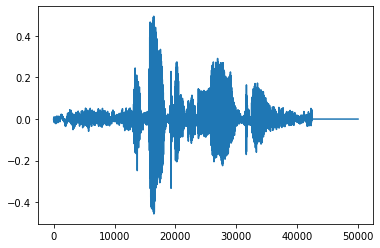

In [ ]:
plt.figure()
# plt.plot(clean[i].numpy())
plt.plot(noisy[i].numpy())

tensor([-1.0000,  1.0000, -1.0000,  ...,  1.0000, -1.0000, -1.0000])


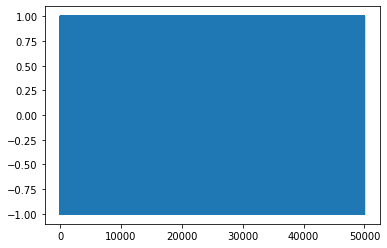

In [ ]:
z = sample_latent(1)
d = gen(noisy[i].view(1,1,var_size).to(device),z.to(device)).cpu().detach()
plt.figure()
plt.plot(d[0][0].numpy())
print(d[0][0])

In [ ]:
torch.save(gen.state_dict(),"./drive/My Drive/models/test_gen_2_1.pt")
torch.save(dis.state_dict(),"./drive/My Drive/models/test_dis_2_1.pt")

## reloading Last Best Model

In [ ]:
dis = CNN_Discriminator().to(device)
gen = CNN_Generator().to(device)

In [ ]:
gen.load_state_dict(torch.load("./drive/My Drive/models/gen_hooha.pt"))

<All keys matched successfully>

In [ ]:
dis.load_state_dict(torch.load("./drive/My Drive/models/dis_hooha.pt"))

<All keys matched successfully>

In [ ]:
clean,noisy = load_data()

In [ ]:
i = 4

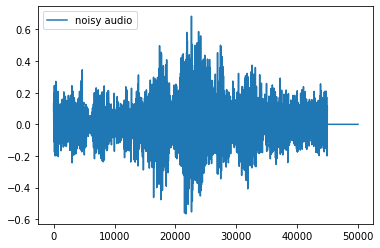

In [ ]:
plt.figure()
plt.plot(noisy[i].numpy(), label='noisy audio')
plt.legend(loc="upper left")
# plt.plot(clean[i].numpy())

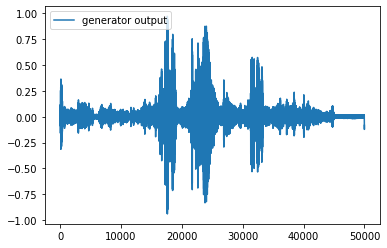

In [ ]:
z = sample_latent(1)
d = gen(noisy[i].view(1,1,var_size).to(device),z.to(device)).cpu().detach()
plt.figure()
plt.plot(d[0][0].numpy(), label='generator output')
plt.legend(loc="upper left")

In [ ]:
print("THANKS")

THANKS
